In [1]:
from typing import List

from oop_functions.experiment_helper import *
from oop_functions.experiment_runner import ExperimentRunner
from oop_functions.util_functions import *
from oop_functions.visualization_util import *
from oop_functions.analytics_cv_util import *
from oop_functions.analytics_utils import *

%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns

from xgboost import XGBClassifier

import itertools




Cross-Validation measures:
+--------------------+----------+-------------+-----------+----------+
|                    |     mean |         std |       min |      max |
|--------------------+----------+-------------+-----------+----------|
| precision__class_0 | 0.999684 | 0.000158137 | 0.99946   | 1        |
| recall__class_0    | 0.996703 | 0.000878504 | 0.99456   | 0.997955 |
| f1-score__class_0  | 0.998191 | 0.000483569 | 0.997094  | 0.998976 |
| precision__class_1 | 0.125913 | 0.0555177   | 0.05      | 0.258065 |
| recall__class_1    | 0.588889 | 0.202212    | 0.25      | 1        |
| f1-score__class_1  | 0.206582 | 0.0867177   | 0.0833333 | 0.410256 |
| accuracy           | 0.996391 | 0.000963125 | 0.994208  | 0.997956 |
| auc                | 0.945693 | 0.0422409   | 0.848166  | 0.999689 |
+--------------------+----------+-------------+-----------+----------+


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


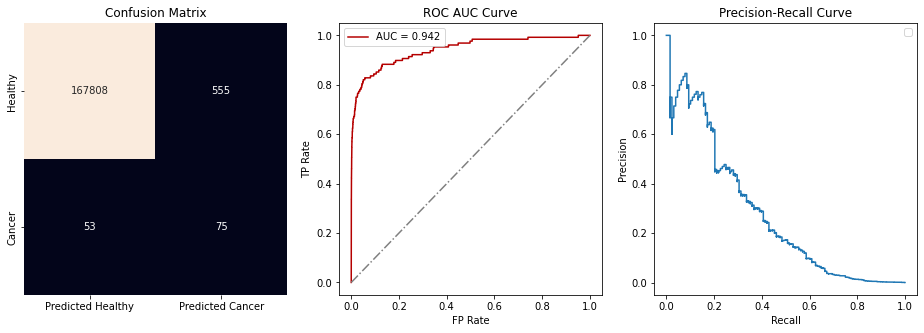

In [3]:
single_cv_analytics_util = load_cv_analytics_util_see_stats('experiment_participants_screened_single_first_5_XGBClassifier_for_cancer_in_next_1_years_15_trials')

In [4]:
single_test_cols = single_cv_analytics_util.analytics_utils[0].data_util.test_df.columns.to_list()

In [5]:
len(single_test_cols)

152

In [6]:
id_col = 'index'
label = 'cancer_in_next_1_years'
id_and_confidence = []
for analytics_util in single_cv_analytics_util.analytics_utils:
    X_test = analytics_util.data_util.test_df[[id_col, 'plco_id', label]]
    X_test_mismatch = X_test.copy()
    y_pred, y_prob = analytics_util.get_predictions() 
    X_test_mismatch[f'{label}_pred'] = y_pred
    X_test_mismatch[f'{label}_prob'] = y_prob
    X_test_mismatch = X_test_mismatch[X_test_mismatch[label] != X_test_mismatch[f'{label}_pred']]
    X_test_mismatch = X_test_mismatch[X_test_mismatch[label] == 1]
    id_and_confidence.append(X_test_mismatch)
mid_conf_predictions = pd.concat(id_and_confidence)



Cross-Validation measures:
+--------------------+-----------+-------------+-----------+----------+
|                    |      mean |         std |       min |      max |
|--------------------+-----------+-------------+-----------+----------|
| precision__class_0 | 0.999562  | 0.000239493 | 0.998928  | 0.999823 |
| recall__class_0    | 0.996691  | 0.00105116  | 0.995118  | 0.99876  |
| f1-score__class_0  | 0.998124  | 0.000521025 | 0.99742   | 0.999025 |
| precision__class_1 | 0.0987882 | 0.0740179   | 0.0192308 | 0.3      |
| recall__class_1    | 0.423753  | 0.208265    | 0.0769231 | 0.777778 |
| f1-score__class_1  | 0.153034  | 0.0953184   | 0.0357143 | 0.352941 |
| accuracy           | 0.996257  | 0.00103829  | 0.994854  | 0.998054 |
| auc                | 0.840406  | 0.101479    | 0.682149  | 0.981976 |
+--------------------+-----------+-------------+-----------+----------+


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


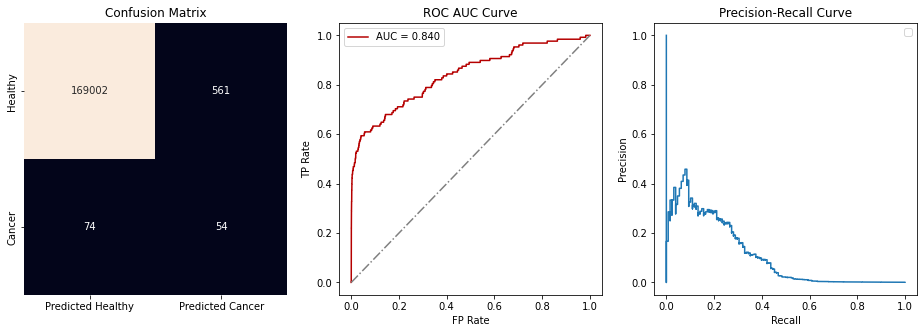

In [7]:
cv_analytics_util = load_cv_analytics_util_see_stats('experiment_participants_screened_first_5_XGBClassifier_for_cancer_in_next_1_years_15_trials')

In [8]:
cv_analytics_util.store_cv_results()



Cross-Validation measures:
+--------------------+-----------+-------------+-----------+----------+
|                    |      mean |         std |       min |      max |
|--------------------+-----------+-------------+-----------+----------|
| precision__class_0 | 0.999562  | 0.000239493 | 0.998928  | 0.999823 |
| recall__class_0    | 0.996691  | 0.00105116  | 0.995118  | 0.99876  |
| f1-score__class_0  | 0.998124  | 0.000521025 | 0.99742   | 0.999025 |
| precision__class_1 | 0.0987882 | 0.0740179   | 0.0192308 | 0.3      |
| recall__class_1    | 0.423753  | 0.208265    | 0.0769231 | 0.777778 |
| f1-score__class_1  | 0.153034  | 0.0953184   | 0.0357143 | 0.352941 |
| accuracy           | 0.996257  | 0.00103829  | 0.994854  | 0.998054 |
| auc                | 0.840406  | 0.101479    | 0.682149  | 0.981976 |
+--------------------+-----------+-------------+-----------+----------+




Cross-Validation measures:
+--------------------+------------+-------------+-------------+-----------+
|                    |       mean |         std |         min |       max |
|--------------------+------------+-------------+-------------+-----------|
| precision__class_0 | 0.999686   | 0.000244708 | 0.999041    | 1         |
| recall__class_0    | 0.91806    | 0.0103036   | 0.897315    | 0.932479  |
| f1-score__class_0  | 0.957107   | 0.0055678   | 0.945835    | 0.964883  |
| precision__class_1 | 0.00576415 | 0.00275662  | 0.000961538 | 0.0113507 |
| recall__class_1    | 0.625041   | 0.237991    | 0.166667    | 1         |
| f1-score__class_1  | 0.0114085  | 0.00543022  | 0.00191205  | 0.0223464 |
| accuracy           | 0.917831   | 0.010213    | 0.8973      | 0.932185  |
| auc                | 0.840406   | 0.101479    | 0.682149    | 0.981976  |
+--------------------+------------+-------------+-------------+-----------+


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


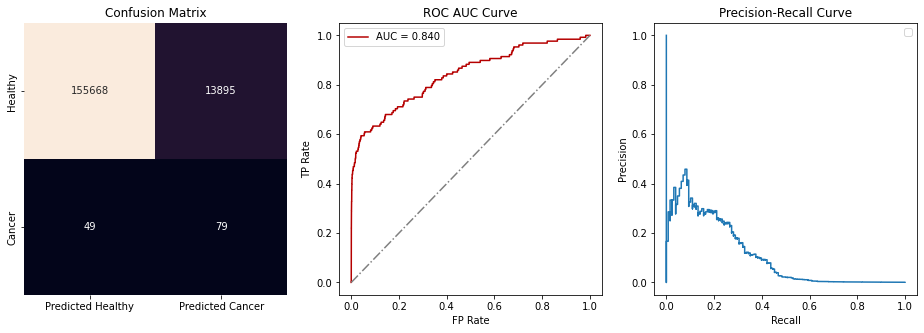

In [9]:
cv_analytics_util.update_thresholds(0.03)
cv_analytics_util.get_cv_report();
cv_analytics_util.display_graph()

In [10]:
test_cols = cv_analytics_util.analytics_utils[0].data_util.test_df.columns.to_list()

In [11]:
for col in test_cols:
    if col not in single_test_cols:
        print(col)

In [12]:
from oop_functions.util_functions import summarize_features, print_df, convert_numeric_to_float16

processed_data = pd.read_csv('./processed_dataset/recent_propagated_dataset.csv', index_col=0)
processed_data = convert_numeric_to_float16(processed_data)

In [13]:
processed_data[processed_data['ovar_cancer_years']  < processed_data['ovar_observe_year']][['ovar_cancer_years', 'study_yr', 'cancer_in_next_1_years', 'ovar_observe_year']]

,ovar_cancer_years,study_yr,cancer_in_next_1_years,ovar_observe_year


In [14]:

processed_data['ca125ii_level_binary'] = np.nan
processed_data.loc[processed_data['ca125ii_level'] < 35, 'ca125ii_level_binary'] = 1
processed_data.loc[processed_data['ca125ii_level'] >= 35 , 'ca125ii_level_binary'] = 2

In [15]:
# TODO: fix this one

In [16]:
cv_analytics_util.analytics_utils[0].data_util.imputer.impute_mean_cols == single_cv_analytics_util.analytics_utils[0].data_util.imputer.impute_mean_cols

True

In [17]:
full_dataset_single_original = get_dataset_with_predictions(single_cv_analytics_util, id_col = 'index', label = 'cancer_in_next_1_years')

In [18]:
# Create a copy of the whole dataset
label = 'cancer_in_next_1_years'
full_dataset = []
for analytics_util in cv_analytics_util.analytics_utils:
    X_test = analytics_util.data_util.test_df
    full_dataset.append(X_test.copy())
full_dataset = pd.concat(full_dataset)
processed_data = processed_data[full_dataset.columns]
full_dataset = processed_data[processed_data[id_col].isin(full_dataset[id_col])]


In [19]:
df_1 = single_cv_analytics_util.analytics_utils[0].data_util.test_df

In [20]:
df_1[df_1['cancer_in_next_1_years'] == 1][['index']]

,index
228,104.0
1412,116523.0
3046,1466.0
3188,191453.0
3777,79069.0
4414,117192.0
4752,154676.0
7808,79967.0
9633,155752.0


In [21]:
# single_cv_analytics_util.analytics_utils[0].data_util.test_df.columns == full_dataset.columns

In [22]:
single_cv_analytics_util.analytics_utils[0].data_util.imputer.imputer_mean.statistics_[-61]

1.0111262794259968

In [23]:
single_cv_analytics_util.analytics_utils[0].data_util.imputer.impute_mean_cols

['cancer_in_next_1_years',
 'ovarsumm_fh_cnt',
 'fmenstr',
 'benign_ovcyst',
 'tubal',
 'bmi_50c',
 'stillb',
 'pelvic_history',
 'miscar',
 'age',
 'colon_comorbidity',
 'breast_fh',
 'ovcyst_diam',
 'sepst',
 'tvu_ref',
 'usound_history',
 'breast_fh_cnt',
 'ca125_result',
 'cig_stop',
 'educat',
 'sisters',
 'study_yr',
 'ovary_diaml',
 'pregc',
 'ovary_trial_flag',
 'weight20_f',
 'ovary_voll',
 'horm_f',
 'hystera',
 'hispanic_f',
 'asp',
 'lantero_p',
 'ovary_volr',
 'gallblad_f',
 'hyperten_f',
 'endometriosis',
 'ltran_p',
 'ovar_days',
 'was_screened',
 'diabetes_f',
 'mammo_history',
 'ovar_result',
 'cigar',
 'papsmear_history',
 'menstrs',
 'smokea_f',
 'breast_fh_age',
 'bcontrt',
 'detr_p',
 'fh_cancer',
 'cig_stat',
 'cigpd_f',
 'height_f',
 'bmi_20',
 'curhorm',
 'weight_f',
 'polyps_f',
 'bcontr_f',
 'ibup',
 'ovariesr_f',
 'ca125ii_level',
 'maxdi',
 'prega',
 'post_menopausal',
 'ibuppd',
 'stroke_f',
 'arthrit_f',
 'bcontra',
 'bronchit_f',
 'ovary_diam',
 'llong_p'

In [24]:
# full_dataset = full_dataset_single_original

In [25]:
# Add those records to the test datasets of the single label dataset and test its validity
for analytics_util in single_cv_analytics_util.analytics_utils:
    # print(analytics_util.data_util.test_df.shape)
    idx = analytics_util.data_util.test_df['plco_id'].to_list()
    # print((full_dataset[full_dataset['plco_id'].isin(idx)].shape))
    analytics_util.data_util.test_df = full_dataset[full_dataset['plco_id'].isin(idx)]
    analytics_util.data_util.test_df = analytics_util.data_util.imputer.imputer_transform(analytics_util.data_util.test_df)


In [26]:
df_2 = single_cv_analytics_util.analytics_utils[0].data_util.test_df

In [27]:
df_1[df_1['index'] == 228522]

,plco_id,age,agelevel,arthrit_f,asp,asppd,bbd,bcontr_f,bcontra,bcontrt,...,uterine_fib,visboth,viseith,visl,visr,volum,was_screened,weight20_f,weight50_f,weight_f
3732,A-077228-7,70.0,2.0,0.0,1.0,1.0,0.0,1.0,2.0,5.0,...,1.0,0.0,0.0,0.0,0.0,10.0625,1.0,127.0,118.0,125.0


In [28]:
df_2[df_2['index'] == 228522]

,plco_id,age,agelevel,arthrit_f,asp,asppd,bbd,bcontr_f,bcontra,bcontrt,...,uterine_fib,visboth,viseith,visl,visr,volum,was_screened,weight20_f,weight50_f,weight_f
228522,A-077228-7,70.0,2.0,0.0,1.0,1.0,0.0,1.0,2.0,5.0,...,1.0,0.0,0.0,0.0,0.0,10.06438,1.0,127.0,118.0,125.0


In [29]:
# Add those records to the test datasets of the single label dataset and test its validity
# for analytics_util in single_cv_analytics_util.analytics_utils:
#     idx = analytics_util.data_util.train_df['index'].to_list()
#     analytics_util.data_util.train_df = full_dataset[full_dataset['index'].isin(idx)]
#     analytics_util.data_util.train_df = analytics_util.data_util.imputer.imputer_transform(analytics_util.data_util.train_df)
#     analytics_util.fit()




Cross-Validation measures:
+--------------------+------------+-------------+-------------+------------+
|                    |       mean |         std |         min |        max |
|--------------------+------------+-------------+-------------+------------|
| precision__class_0 | 0.999618   | 0.000191798 | 0.99933     | 1          |
| recall__class_0    | 0.822777   | 0.0199557   | 0.783704    | 0.85368    |
| f1-score__class_0  | 0.902494   | 0.012069    | 0.878606    | 0.920799   |
| precision__class_1 | 0.00253765 | 0.000873406 | 0.000891266 | 0.0042061  |
| recall__class_1    | 0.588889   | 0.202212    | 0.25        | 1          |
| f1-score__class_1  | 0.00505321 | 0.00173899  | 0.0017762   | 0.00837696 |
| accuracy           | 0.822597   | 0.0199502   | 0.783591    | 0.853262   |
| auc                | 0.763914   | 0.0922725   | 0.635726    | 0.940546   |
+--------------------+------------+-------------+-------------+------------+


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


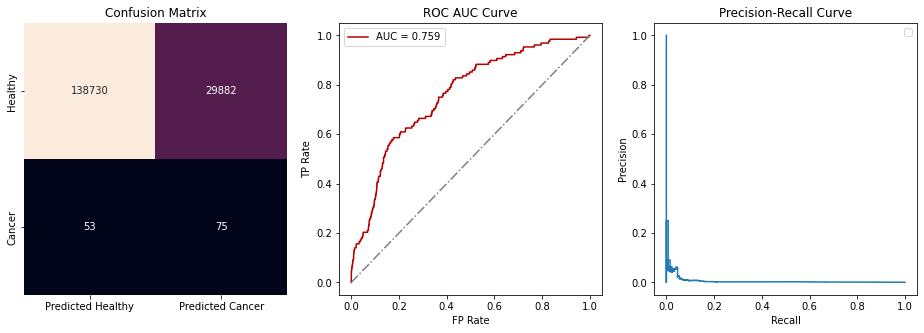

In [30]:
single_cv_analytics_util.update_thresholds(0.5)
single_cv_analytics_util.get_cv_report();
single_cv_analytics_util.display_graph()

In [31]:
full_dataset_single_new = get_dataset_with_predictions(single_cv_analytics_util, id_col = 'index', label = 'cancer_in_next_1_years')

In [32]:
plco_id = 228522

In [33]:
full_dataset_single_new[full_dataset_single_new['cancer_in_next_1_years_prob'] > 0.9]['index']

26            26.0
29            29.0
45            45.0
104          104.0
232          232.0
            ...   
264645    264645.0
264670    264670.0
264676    264676.0
264684    264684.0
264700    264700.0
Name: index, Length: 18774, dtype: float64

In [34]:
processed_data[processed_data['index'] == plco_id]

,plco_id,age,agelevel,arthrit_f,asp,asppd,bbd,bcontr_f,bcontra,bcontrt,...,uterine_fib,visboth,viseith,visl,visr,volum,was_screened,weight20_f,weight50_f,weight_f
228522,A-077228-7,70.0,2.0,0.0,1.0,1.0,0.0,1.0,2.0,5.0,...,1.0,0.0,0.0,0.0,0.0,NaN,1.0,127.0,118.0,125.0


In [35]:
full_dataset_single_original[full_dataset_single_original['index'] == plco_id]

,plco_id,age,agelevel,arthrit_f,asp,asppd,bbd,bcontr_f,bcontra,bcontrt,...,viseith,visl,visr,volum,was_screened,weight20_f,weight50_f,weight_f,cancer_in_next_1_years_pred,cancer_in_next_1_years_prob
3732,A-077228-7,70.0,2.0,0.0,1.0,1.0,0.0,1.0,2.0,5.0,...,0.0,0.0,0.0,10.0625,1.0,127.0,118.0,125.0,1,0.755356


In [36]:
full_dataset_single_new[full_dataset_single_new['index'] == plco_id]

,plco_id,age,agelevel,arthrit_f,asp,asppd,bbd,bcontr_f,bcontra,bcontrt,...,viseith,visl,visr,volum,was_screened,weight20_f,weight50_f,weight_f,cancer_in_next_1_years_pred,cancer_in_next_1_years_prob
228522,A-077228-7,70.0,2.0,0.0,1.0,1.0,0.0,1.0,2.0,5.0,...,0.0,0.0,0.0,10.06438,1.0,127.0,118.0,125.0,1,0.755356


In [37]:
id_col = 'index'
label = 'cancer_in_next_1_years'
id_and_confidence = []
for analytics_util in cv_analytics_util.analytics_utils:
    X_test = analytics_util.data_util.test_df[[id_col, 'plco_id', label]]
    X_test_mismatch = X_test.copy()
    y_pred, y_prob = analytics_util.get_predictions() 
    X_test_mismatch[f'{label}_pred'] = y_pred
    X_test_mismatch[f'{label}_prob'] = y_prob
    X_test_mismatch = X_test_mismatch[X_test_mismatch[label] != X_test_mismatch[f'{label}_pred']]
    X_test_mismatch = X_test_mismatch[X_test_mismatch[label] == 1]
    id_and_confidence.append(X_test_mismatch)
mid_conf_predictions_2 = pd.concat(id_and_confidence)

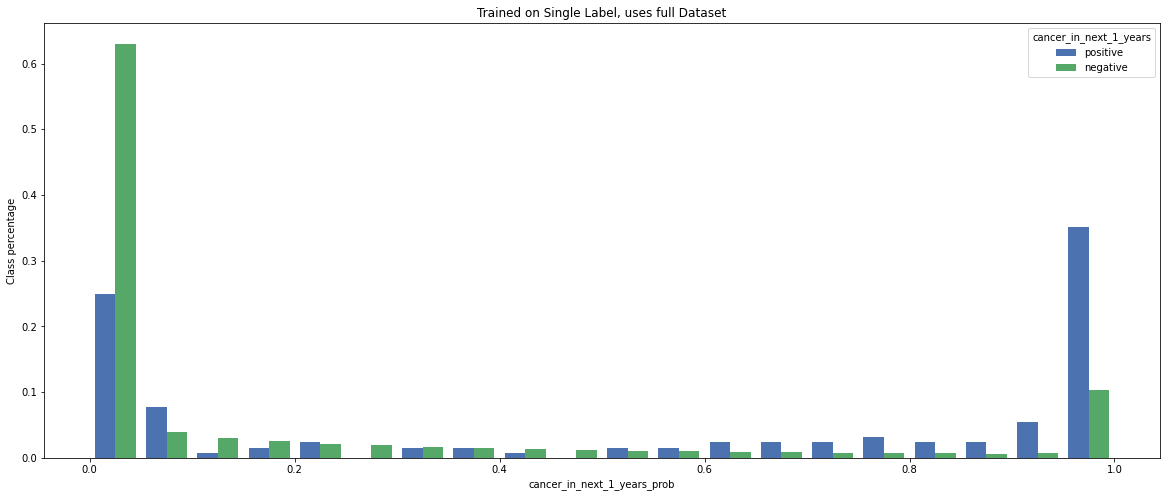

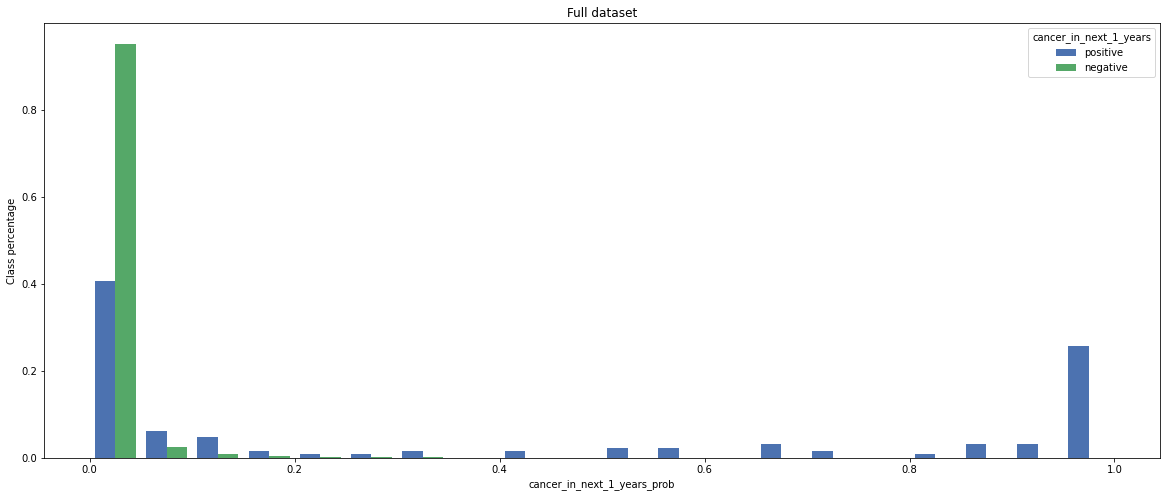

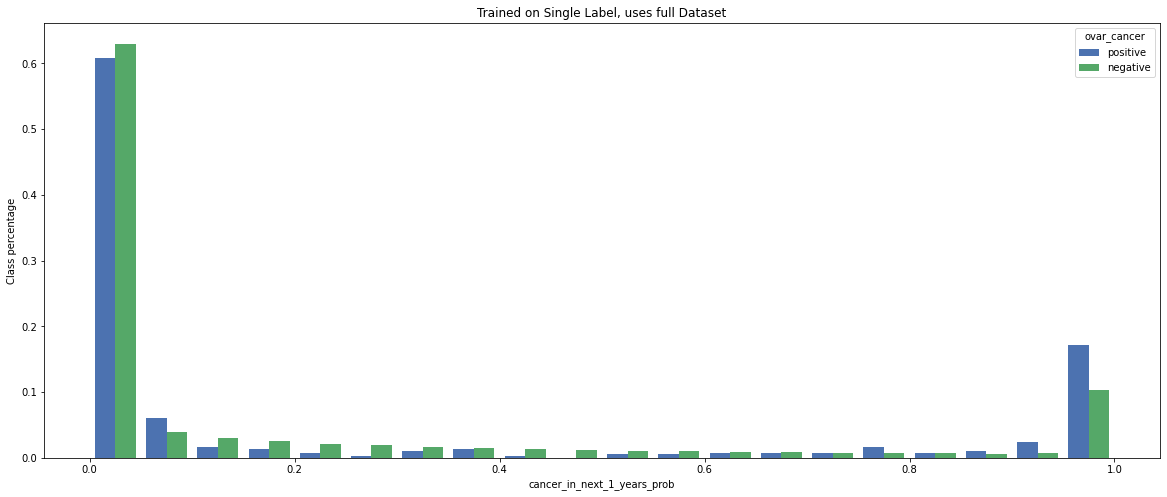

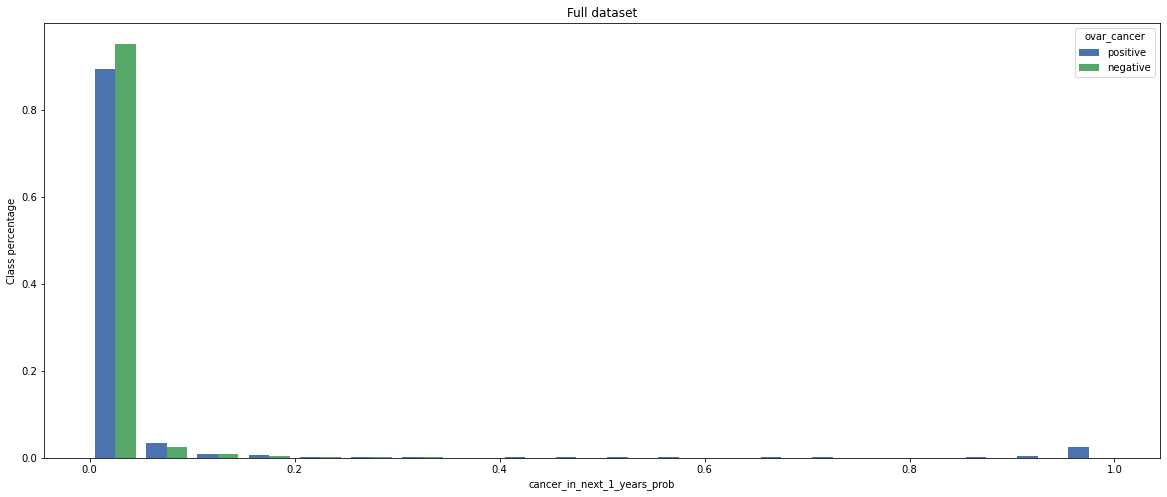

In [38]:

full_dataset = get_dataset_with_predictions(single_cv_analytics_util, id_col = 'index', label = 'cancer_in_next_1_years')
plot_hist_side_by_side_for_class(full_dataset, 'cancer_in_next_1_years', 'cancer_in_next_1_years_prob', normalize = True, title='Trained on Single Label, uses full Dataset')
full_dataset = get_dataset_with_predictions(cv_analytics_util, id_col = 'index', label = 'cancer_in_next_1_years')
plot_hist_side_by_side_for_class(full_dataset, 'cancer_in_next_1_years', 'cancer_in_next_1_years_prob', normalize = True, title='Full dataset')

full_dataset = get_dataset_with_predictions(single_cv_analytics_util, id_col = 'index', label = 'cancer_in_next_1_years')
plot_hist_side_by_side_for_class(full_dataset, 'ovar_cancer', 'cancer_in_next_1_years_prob', normalize = True, title='Trained on Single Label, uses full Dataset')
full_dataset = get_dataset_with_predictions(cv_analytics_util, id_col = 'index', label = 'cancer_in_next_1_years')
plot_hist_side_by_side_for_class(full_dataset, 'ovar_cancer', 'cancer_in_next_1_years_prob', normalize = True, title='Full dataset')

In [39]:
print([col for col in full_dataset.columns if 'year' in col])

['cancer_in_next_1_years', 'cig_years', 'ovar_cancer_years', 'ovar_observe_year', 'pack_years', 'cancer_in_next_1_years_pred', 'cancer_in_next_1_years_prob']




Cross-Validation measures:
+--------------------+-------------+-------------+----------+------------+
|                    |        mean |         std |      min |        max |
|--------------------+-------------+-------------+----------+------------|
| precision__class_0 | 0.999024    | 0.000196161 | 0.998688 | 0.999287   |
| recall__class_0    | 0.948909    | 0.00549857  | 0.941153 | 0.96018    |
| f1-score__class_0  | 0.973314    | 0.00285674  | 0.969206 | 0.979144   |
| precision__class_1 | 0.000645899 | 0.000779529 | 0        | 0.00219539 |
| recall__class_1    | 0.0356409   | 0.0432091   | 0        | 0.117647   |
| f1-score__class_1  | 0.00126781  | 0.00153005  | 0        | 0.00431034 |
| accuracy           | 0.948031    | 0.00542217  | 0.940259 | 0.959141   |
| auc                | 0.513652    | 0.0819359   | 0.373588 | 0.673209   |
+--------------------+-------------+-------------+----------+------------+


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


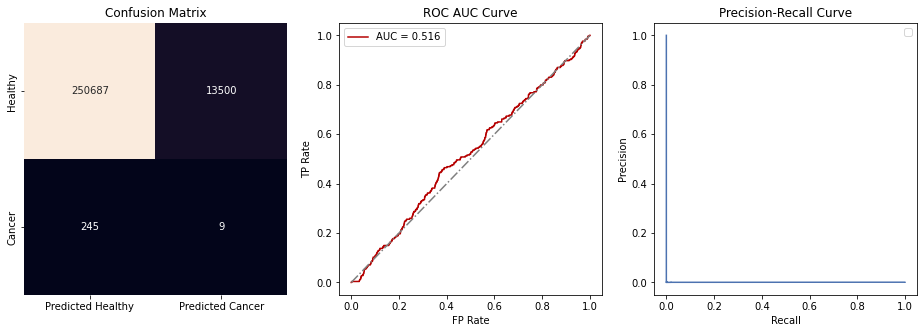

In [40]:
cv_analytics_util_not_screened = load_cv_analytics_util_see_stats('experiment_not_screened_cols_first_5_XGBClassifier_for_cancer_in_next_1_years_15_trials')

In [41]:
def extract_full_dataset_filter_cancer(cv_analytics_util):
    full_dataset = get_dataset_with_predictions(cv_analytics_util, id_col = 'index', label = 'cancer_in_next_1_years')
    full_dataset = full_dataset[full_dataset['ovar_cancer'] == 1]
    full_dataset = full_dataset[full_dataset['ovar_cancer_years'] <= 5]
    return full_dataset

def plot_diff_in_confidence(full_dataset, title=''):
    
    grouped_df = full_dataset.groupby(['plco_id'])
    diff_df = []

    for key, item in grouped_df:
        diff = {}
        group = grouped_df.get_group(key)
        group = group.sort_values('study_yr').reset_index()
        diff['plco_id'] = group.loc[0, 'plco_id']
        years = group['study_yr'].unique()
        max_year = 6 - len(years)
        # max_year = 0
        for year in range(len(years) - 1):
            diff[f'cancer_in_next_1_years_{int(max_year + year+1)}-{int(max_year + year)}'] = group.loc[year+1, 'cancer_in_next_1_years_prob'] - group.loc[year, 'cancer_in_next_1_years_prob']
            # if len(years) == 5:
            #     print(diff)
        diff_df.append(diff)

    ordered_cols = []
    for i in range(5):
        ordered_cols.append(f'cancer_in_next_1_years_{i+1}-{i}')
        
    diff_df = pd.DataFrame(diff_df)

    diff_df = diff_df[['plco_id'] + ordered_cols]
    print_df(diff_df.describe().T)
    x = list(range(-1, -6, -1))
    stats = diff_df.describe()
    y = np.array(stats.loc['mean'].to_list())
    ci = np.array(stats.loc['std'].to_list())
    plt.plot(x, y)
    plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)
    plt.ylabel("Probability of getting cancer")
    plt.xlabel("Years before getting cancer")
    plt.ylim([0, 1])
    plt.title(title)

In [42]:
def plot_change_in_confidence(full_dataset, title = ''):    
    grouped_df = full_dataset.groupby(['plco_id'])
    diff_df = []

    for key, item in grouped_df:
        diff = {}
        group = grouped_df.get_group(key)
        group = group.sort_values('study_yr').reset_index()
        diff['plco_id'] = group.loc[0, 'plco_id']
        years = group['study_yr'].unique()
        max_year = 6 - len(years)
        # max_year = 0
        for year in range(len(years)):
            diff[f'cancer_in_next_1_years_{int(max_year + year)}'] = group.loc[year, 'cancer_in_next_1_years_prob']
            # if len(years) == 5:
            #     print(diff)
        diff_df.append(diff)

    ordered_cols = []
    for i in range(6):
        ordered_cols.append(f'cancer_in_next_1_years_{i}')

    diff_df = pd.DataFrame(diff_df)

    diff_df = diff_df[['plco_id'] + ordered_cols]
    print_df(diff_df.describe().T)
    x = sorted(list(range(-1, -7, -1)))
    stats = diff_df.describe()
    y = np.array(stats.loc['mean'].to_list())
    ci = np.array(stats.loc['std'].to_list())
    plt.plot(x, y)
    plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)
    plt.ylabel("Probability of getting cancer")
    plt.xlabel("Years before getting cancer")
    plt.ylim([0, 1])
    plt.title(title)

In [43]:
list(range(-1, -7, -1))

[-1, -2, -3, -4, -5, -6]

In [44]:
# plot_diff_in_confidence(cv_analytics_util_not_screened, title='Year over year change in probability before getting cancer based on questionaire')

X-axis -1 means that somewhere withing the next year person gets cancer. -2 means somewhere between year -1 and 0 person gets cancer.

+--------------------------+---------+----------+-----------+------------+-----------+----------+----------+----------+
|                          |   count |     mean |       std |        min |       25% |      50% |      75% |      max |
|--------------------------+---------+----------+-----------+------------+-----------+----------+----------+----------|
| cancer_in_next_1_years_0 |       9 | 0.16027  | 0.0848197 | 0.0258791  | 0.106527  | 0.187424 | 0.209869 | 0.259723 |
| cancer_in_next_1_years_1 |      25 | 0.184544 | 0.138238  | 0.00597105 | 0.0910368 | 0.16441  | 0.241776 | 0.507592 |
| cancer_in_next_1_years_2 |      46 | 0.182407 | 0.134976  | 0.00597105 | 0.0691004 | 0.178442 | 0.249272 | 0.530985 |
| cancer_in_next_1_years_3 |      65 | 0.16424  | 0.125541  | 0.00597105 | 0.0566195 | 0.150447 | 0.241776 | 0.530985 |
| cancer_in_next_1_years_4 |      95 | 0.160061 | 0.123516  | 0.00597105 | 0.0537119 | 0.131553 | 0.234106 | 0.530985 |
| cancer_in_next_1_years_5 |     254 | 0

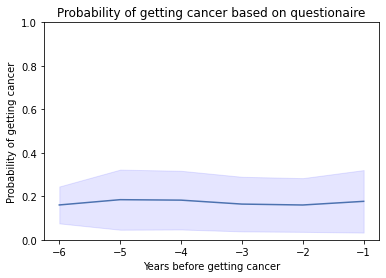

In [45]:
full_dataset = extract_full_dataset_filter_cancer(cv_analytics_util_not_screened)
plot_change_in_confidence(full_dataset, title='Probability of getting cancer based on questionaire')

+--------------------------+---------+-----------+------------+-------------+------------+------------+------------+-----------+
|                          |   count |      mean |        std |         min |        25% |        50% |        75% |       max |
|--------------------------+---------+-----------+------------+-------------+------------+------------+------------+-----------|
| cancer_in_next_1_years_0 |       9 | 0.0060468 | 0.00606549 | 0.000916826 | 0.0023136  | 0.00397556 | 0.00682769 | 0.0200179 |
| cancer_in_next_1_years_1 |      25 | 0.0156277 | 0.0480942  | 0.00081507  | 0.00152057 | 0.00410402 | 0.00597299 | 0.243356  |
| cancer_in_next_1_years_2 |      46 | 0.02326   | 0.107049   | 0.000344576 | 0.00156999 | 0.00374851 | 0.00681633 | 0.727591  |
| cancer_in_next_1_years_3 |      65 | 0.0318939 | 0.123309   | 0.000337782 | 0.00187418 | 0.0043959  | 0.0135773  | 0.932168  |
| cancer_in_next_1_years_4 |      95 | 0.0533713 | 0.155891   | 0.000205243 | 0.00236547 | 0.0056

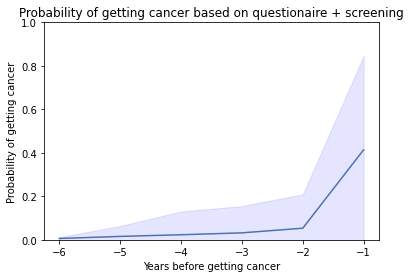

In [46]:
full_dataset = extract_full_dataset_filter_cancer(cv_analytics_util)
plot_change_in_confidence(full_dataset, title='Probability of getting cancer based on questionaire + screening')

+--------------------------+---------+-----------+-----------+-------------+------------+------------+------------+----------+
|                          |   count |      mean |       std |         min |        25% |        50% |        75% |      max |
|--------------------------+---------+-----------+-----------+-------------+------------+------------+------------+----------|
| cancer_in_next_1_years_0 |   21891 | 0.0114441 | 0.0408512 | 6.11693e-05 | 0.00124994 | 0.00293726 | 0.00799601 | 0.994994 |
| cancer_in_next_1_years_1 |   25366 | 0.0128135 | 0.0455239 | 6.96136e-05 | 0.00121616 | 0.00292652 | 0.00823596 | 0.994547 |
| cancer_in_next_1_years_2 |   27192 | 0.0128201 | 0.0463972 | 5.68516e-05 | 0.0012292  | 0.00297652 | 0.00819854 | 0.995431 |
| cancer_in_next_1_years_3 |   28787 | 0.0135789 | 0.0534727 | 6.34739e-05 | 0.00122739 | 0.00298699 | 0.00825662 | 0.997351 |
| cancer_in_next_1_years_4 |   30816 | 0.0144876 | 0.0530063 | 6.34295e-05 | 0.00133703 | 0.00323805 | 0.009026

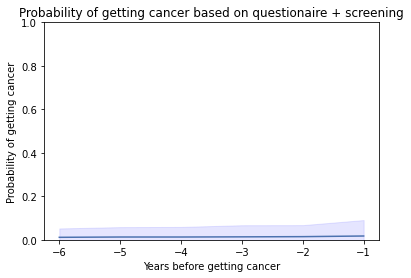

In [47]:
full_dataset = get_dataset_with_predictions(cv_analytics_util, id_col = 'index', label = 'cancer_in_next_1_years')
plot_change_in_confidence(full_dataset, title='Probability of getting cancer based on questionaire + screening')

In [48]:
full_dataset = get_dataset_with_predictions(cv_analytics_util, id_col = 'index', label = 'cancer_in_next_1_years')

threshold = 0.2
idx = full_dataset[(full_dataset['cancer_in_next_1_years_prob'] >= threshold) & (full_dataset['ovar_cancer'] == 0)]['plco_id'].unique()
full_dataset = full_dataset[full_dataset['plco_id'].isin(idx)]
full_dataset = full_dataset[full_dataset['study_yr'] >= 0]
full_dataset = full_dataset[full_dataset['ovar_observe_year'] <= 5]
dict_years_pred = {}
 
for plco_id in full_dataset['plco_id'].unique():
    # TODO: i can change min and max
    dict_years_pred[plco_id] = full_dataset[(full_dataset['plco_id'] == plco_id) & (full_dataset['cancer_in_next_1_years_prob'] >= threshold)]['ovar_observe_year'].min()
    full_dataset = full_dataset[((full_dataset['plco_id'] == plco_id) & (full_dataset['ovar_observe_year'] <= dict_years_pred[plco_id])) | (full_dataset['plco_id'] != plco_id)]

+--------------------------+---------+-----------+-----------+-------------+------------+------------+-----------+----------+
|                          |   count |      mean |       std |         min |        25% |        50% |       75% |      max |
|--------------------------+---------+-----------+-----------+-------------+------------+------------+-----------+----------|
| cancer_in_next_1_years_0 |      51 | 0.0347114 | 0.0470316 | 0.00070374  | 0.00387648 | 0.00936225 | 0.0586033 | 0.19639  |
| cancer_in_next_1_years_1 |     130 | 0.0323167 | 0.0412728 | 0.000248389 | 0.0033639  | 0.0126271  | 0.0483559 | 0.190926 |
| cancer_in_next_1_years_2 |     239 | 0.0336597 | 0.0429594 | 0.000405801 | 0.00400922 | 0.0148624  | 0.0455947 | 0.190926 |
| cancer_in_next_1_years_3 |     383 | 0.037677  | 0.0476812 | 0.000156057 | 0.00443172 | 0.0158512  | 0.052857  | 0.194943 |
| cancer_in_next_1_years_4 |     564 | 0.0445708 | 0.0497967 | 0.000253632 | 0.0066952  | 0.0236379  | 0.0689814 | 0.1

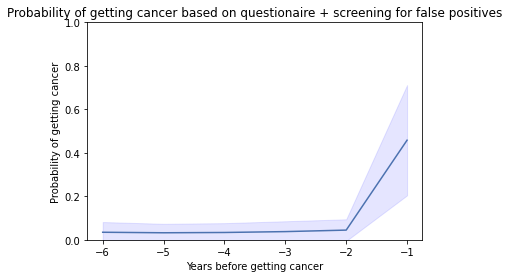

In [49]:
# full_dataset = full_dataset[full_dataset['cancer_in_next_1_years_prob'] >= threshold]
plot_change_in_confidence(full_dataset, title='Probability of getting cancer based on questionaire + screening for false positives')